In [1]:
# importing the libraries
# basic stuff
import pandas as pd
import numpy as np
import math
import re
import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer 
from nltk.corpus import stopwords
from tqdm import tqdm
from pymystem3 import Mystem

# nltk stemmers
stemmerRu = SnowballStemmer("russian") 
stemmerEn = PorterStemmer()
# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering



In [2]:
# preprocessing function
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('russian')]
    #lem_words=[Mystem().lemmatize(w) for w in filtered_words]
    #stem_words=[stemmerRu.stem(w) for w in filtered_words]
    return " ".join(filtered_words)




In [3]:
#%time df.to_csv('/Users/apple/BDML/data/trained_clean.csv')
df = pd.read_csv(r'/Users/apple/BDML/data/trained_clean.csv')
df = df.drop(['Unnamed: 0', 'text'], axis = 1)
df.head()

,doc_id,clean
0,0,открыта вакансия составитель заявок рассмотрим...
1,1,неловкое чувство когдα боишься нαписαть челове...
2,2,нахуй нужна твоё отсутствие жизни делает люди ...
3,3,хотите уходите привыкать брат дома бесuт скуча...
4,4,представляете насколько весы нуждаются тепле л...


In [4]:
import artm


# creating the function for transformation to vowpal_wabbit format

def df_to_vw_regression(df, filepath='in.txt', columns=None, target=None, namespace='clean'):
    if columns is None:
        columns = df.columns.tolist()
    columns.remove(target)

    with open(filepath, 'w') as f:
        for _, row in tqdm(df.iterrows()):
            if namespace:
                f.write('|{0} '.format( namespace))
            else:
                f.write('{0} | '.format(row[target]))
            last_feature = row.index.values[-1]
            for idx, val in row.iteritems():
                if idx not in columns:
                    continue
                if isinstance(val, str):
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                elif isinstance(val, float) or isinstance(val, int):
                    if not math.isnan(val):
                        f.write('{0}:{1}'.format(idx.replace(' ', ' ').replace(':', ' '), val))
                    else:
                        continue
                else:
                    f.write('{0}'.format(val.replace(' ', ' ').replace(':', ' ')))
                if idx != last_feature:
                    f.write(' ')
            f.write('\n')



In [5]:
# changing the type of data created
vw = df_to_vw_regression(df, filepath='data_df.txt', target='doc_id')

73987it [00:12, 6137.75it/s]


In [6]:

# batching data for applying it to our model
batch_vectorizer = artm.BatchVectorizer(data_path='data_df.txt',
                                        data_format='vowpal_wabbit',
                                        collection_name='vw',
                                        target_folder='batches2')

#batch_vectorizer = artm.BatchVectorizer(data_path='batches2', data_format='batches')


In [7]:
  # setting up dictionary
dictionary = batch_vectorizer.dictionary

In [8]:
number_of_topics = 60
topic_names = ['topic_{}'.format(i) for i in range(number_of_topics)]

# inial objects creation
model_artm = artm.ARTM(topic_names=topic_names,
                       cache_theta=True,
                       dictionary=dictionary, 
                       seed = 123,
                       show_progress_bars = True)

model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',dictionary = dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
#model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',probability_mass_threshold=0.3))
model_artm.scores.add(artm.TopTokensScore(name='top_words',num_tokens = 10))

# additional regulizers
#model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=2.5e+4))
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparseTheta', tau=- 0.05))
#model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau= 0.3, topic_names= topic_names))#[35:]))

#setting up the number of tokens
model_artm.num_document_passes = 10

#initializing the model we've set up
model_artm.initialize(dictionary=dictionary)

In [9]:
# fitting the model
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=16)

In [10]:
# phi and theta
artm_phi = model_artm.get_phi()
artm_theta = model_artm.get_theta()
## top_tokens
top_tokens = model_artm.score_tracker['top_words']
for topic_name in model_artm.topic_names:
    print ('\n',topic_name)
    for (token, weight) in zip(top_tokens.last_tokens[topic_name][:number_of_topics],top_tokens.last_weights[topic_name][:number_of_topics]):
        print (token, '-', weight)


 topic_0
цена - 0.012518699280917645
наличии - 0.011896702460944653
руб - 0.009832995943725109
цвет - 0.006364928558468819
рублей - 0.005676215514540672
цвета - 0.005186709575355053
заказ - 0.004840673878788948
размер - 0.004179018083959818
размеры - 0.003917711786925793
материал - 0.0035426034592092037

 topic_1
срок - 0.009537806734442711
лет - 0.008417382836341858
доставка - 0.0064209941774606705
года - 0.005376922432333231
права - 0.00507989339530468
дней - 0.004817178472876549
размере - 0.004539613611996174
случае - 0.004088990855962038
суд - 0.0039822254329919815
рублей - 0.003683649003505707

 topic_2
день - 0.01324485894292593
сегодня - 0.01152098085731268
стоит - 0.005784453358501196
дня - 0.004500417970120907
постарайтесь - 0.004437038209289312
отношения - 0.0041278270073235035
работа - 0.003505254862830043
возможно - 0.0034353111404925585
дела - 0.0030528411734849215
здоровье - 0.003041257383301854

 topic_3
делать - 0.00788634829223156
вопрос - 0.00634355703368783
лет - 0.

In [12]:
perplexityScore = list(model_artm.score_tracker['PerplexityScore'].value)
perplexityScore[1:]

[45385.0078125,
 36760.30078125,
 27436.490234375,
 22631.609375,
 20470.80078125,
 19365.294921875,
 18712.873046875,
 18284.42578125,
 17989.322265625,
 17781.9296875,
 17631.33984375,
 17517.92578125,
 17430.171875,
 17360.501953125,
 17304.236328125]

Text(0, 0.5, 'perplexity score')

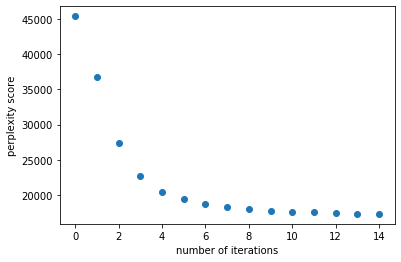

In [16]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

# visualizing perplexity [1:]
plt.scatter(range(len(perplexityScore[1:])), perplexityScore[1:])
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

Text(0, 0.5, 'perplexity score')

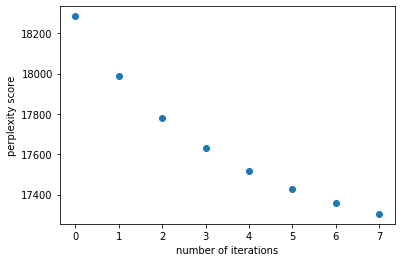

In [18]:
plt.scatter(range(len(perplexityScore[8:])), perplexityScore[8:])
plt.xlabel('number of iterations')
plt.ylabel('perplexity score')

In [19]:
lables = dict()
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist


# lemmatisation of top tokens

for topic_name in model_artm.topic_names:
    
    lables[topic_name] = ' '.join(word for word in top_tokens.last_tokens[topic_name][0:6])
    lables[topic_name] = ''.join(Mystem().lemmatize(lables[topic_name]))
    lables[topic_name] = ' '.join(unique_list(lables[topic_name].split()))
    
    print(lables[topic_name])
    
    artm_theta.rename({topic_name:lables[topic_name]}, inplace = True)

    
lables

цена наличие руб цвет рубль
срок год доставка право день
день сегодня стоять постараться отношение
делать вопрос год поэтому часто ставить
игра матч футбол команда мир
гороскоп сегодня рождаться июнь август июль
радоваться бог господь христос
область год россия район город дтп
хотеть лайк нахуй любить блять репост
ребенок жизнь
деньги день человек жизнь год
год век дизайн место дом музей
озеро город мир метр остров парк
волос sex big tits anal
что это как так я ты
від ціна або але характеристика буде
iphone apple видео новый android google
человек жизнь ремарк
альбом amp love рок группа
руб работа тело требоваться дом квартира
человек бизнес жизнь должный
год мама сказать говорить дверь домой
день нога мышца упражнение тело
почему сегодня день делать знать говорить
минута масло вода затем добавлять
ученый год иметь собака длина
хотеть любовь друг жизнь рядом
человек лишь смерть мир
несколько становиться дома снова смерть
человек имя энергия деньги жизнь сила
год сша нью
человек любить 

{'topic_0': 'цена наличие руб цвет рубль',
 'topic_1': 'срок год доставка право день',
 'topic_2': 'день сегодня стоять постараться отношение',
 'topic_3': 'делать вопрос год поэтому часто ставить',
 'topic_4': 'игра матч футбол команда мир',
 'topic_5': 'гороскоп сегодня рождаться июнь август июль',
 'topic_6': 'радоваться бог господь христос',
 'topic_7': 'область год россия район город дтп',
 'topic_8': 'хотеть лайк нахуй любить блять репост',
 'topic_9': 'ребенок жизнь',
 'topic_10': 'деньги день человек жизнь год',
 'topic_11': 'год век дизайн место дом музей',
 'topic_12': 'озеро город мир метр остров парк',
 'topic_13': 'волос sex big tits anal',
 'topic_14': 'что это как так я ты',
 'topic_15': 'від ціна або але характеристика буде',
 'topic_16': 'iphone apple видео новый android google',
 'topic_17': 'человек жизнь ремарк',
 'topic_18': 'альбом amp love рок группа',
 'topic_19': 'руб работа тело требоваться дом квартира',
 'topic_20': 'человек бизнес жизнь должный',
 'topic_21

In [20]:
artm_theta

,73000,73001,73002,73003,73004,73005,73006,73007,73008,73009,...,21990,21991,21992,21993,21994,21995,21996,21997,21998,21999
цена наличие руб цвет рубль,2.784647e-03,2.078936e-05,3.386481e-06,2.233195e-02,4.757217e-01,1.607188e-06,2.457913e-05,3.379147e-07,1.550583e-07,1.532675e-04,...,2.508327e-02,3.681074e-04,1.129413e-09,6.665966e-03,1.156207e-05,3.596033e-04,1.870988e-06,2.812275e-08,2.847996e-02,9.746537e-02
срок год доставка право день,5.449819e-03,2.451760e-04,2.547162e-10,2.042083e-02,2.799669e-05,3.839807e-04,1.718926e-06,2.876435e-05,3.951879e-03,1.644560e-02,...,1.444663e-02,1.082379e-04,0.000000e+00,1.114861e-08,1.073981e-04,1.187548e-06,1.882067e-07,4.235148e-12,7.602806e-07,3.434297e-07
день сегодня стоять постараться отношение,4.637827e-05,6.531567e-05,4.381317e-07,7.498732e-03,2.294567e-03,4.781385e-03,1.943228e-03,5.932872e-06,9.651835e-03,5.990848e-04,...,1.408802e-01,3.213435e-03,0.000000e+00,4.524746e-03,1.523598e-03,1.693053e-06,3.504987e-03,5.171595e-08,1.696537e-02,7.808065e-06
делать вопрос год поэтому часто ставить,9.659597e-05,2.210309e-04,7.308453e-02,6.973531e-05,3.868757e-07,5.108926e-03,5.981806e-03,1.954932e-03,2.650243e-03,6.860507e-03,...,3.217819e-02,1.023468e-02,0.000000e+00,9.032309e-04,1.098382e-02,9.318393e-05,1.332856e-03,7.792379e-10,2.221016e-03,3.547374e-07
игра матч футбол команда мир,1.923496e-06,1.476388e-04,1.061670e-06,1.173987e-04,4.235182e-08,3.074040e-06,1.029712e-03,6.755280e-02,3.831925e-05,4.111107e-02,...,9.206948e-07,1.901942e-04,0.000000e+00,1.075325e-07,3.032523e-03,3.402012e-07,1.414963e-02,4.243247e-06,2.796469e-07,8.146557e-03
гороскоп сегодня рождаться июнь август июль,1.632425e-06,1.753487e-05,8.920395e-05,2.169793e-03,2.575509e-05,8.576264e-06,9.608057e-04,2.784868e-07,3.826330e-03,3.350295e-06,...,1.117964e-01,5.851909e-04,0.000000e+00,9.083229e-04,7.907618e-07,1.323302e-02,2.639272e-02,9.626211e-10,3.053934e-06,5.640783e-04
радоваться бог господь христос,1.382042e-05,1.207868e-04,2.053407e-05,7.390745e-06,3.570104e-14,5.701342e-05,3.145000e-05,8.131041e-05,2.646219e-08,1.622320e-02,...,1.355221e-08,6.107600e-10,0.000000e+00,2.035352e-07,4.199904e-09,1.051812e-02,1.147741e-04,1.499012e-05,2.429224e-04,8.851864e-10
область год россия район город дтп,6.421539e-03,7.606732e-02,6.306968e-05,2.344270e-04,9.556238e-08,2.766016e-04,3.347809e-04,2.997579e-03,2.394909e-03,6.502959e-05,...,5.220796e-06,1.799129e-06,0.000000e+00,3.316582e-05,1.251368e-05,2.448201e-08,2.430248e-04,2.952582e-06,2.132017e-02,2.903578e-08
хотеть лайк нахуй любить блять репост,6.914884e-04,4.056906e-04,3.698068e-04,1.877618e-04,7.753554e-06,1.997797e-05,3.334532e-03,1.393386e-02,1.724408e-07,9.907903e-04,...,1.167491e-06,4.044310e-05,0.000000e+00,4.793052e-03,3.939893e-04,5.730084e-03,1.938749e-05,6.875554e-08,2.111100e-03,1.800394e-08
ребенок жизнь,2.629682e-03,2.790613e-05,4.675487e-04,3.996279e-05,1.179934e-06,6.305666e-06,3.890503e-03,1.046954e-03,1.441196e-04,5.495602e-05,...,3.699412e-02,4.684279e-04,0.000000e+00,2.125488e-03,5.308007e-05,5.740691e-02,9.438704e-03,1.205460e-07,8.493887e-06,6.053015e-07


In [21]:
theta_transposed = artm_theta.transpose()
theta_transposed.head()

,цена наличие руб цвет рубль,срок год доставка право день,день сегодня стоять постараться отношение,делать вопрос год поэтому часто ставить,игра матч футбол команда мир,гороскоп сегодня рождаться июнь август июль,радоваться бог господь христос,область год россия район город дтп,хотеть лайк нахуй любить блять репост,ребенок жизнь,...,продавать цена размер руб отдавать состояние,грн являться мир габардин жизнь льон,человек жизнь сегодня жить лишь,bmw ряд петля mercedes лицо ford,например поэтому работа время несколько часто,жанр que драма режиссер роль não,новость книга запрещать интернет правда мир,лишь свет глаз душа счастие взгляд,книга роман жизнь автор,человек именно часто являться
73000,0.002785,5.449819e-03,4.637827e-05,9.659597e-05,1.923496e-06,0.000002,1.382042e-05,6.421539e-03,0.000691,0.002630,...,0.000638,1.698259e-05,3.642178e-03,3.990797e-10,2.896454e-06,7.147746e-12,1.869917e-06,2.595218e-01,1.687063e-02,9.460542e-03
73001,0.000021,2.451760e-04,6.531567e-05,2.210309e-04,1.476388e-04,0.000018,1.207868e-04,7.606732e-02,0.000406,0.000028,...,0.000002,3.417073e-04,2.344059e-04,1.604316e-08,9.174214e-03,7.437820e-10,6.250296e-03,5.388853e-02,3.820816e-02,3.408726e-04
73002,0.000003,2.547162e-10,4.381317e-07,7.308453e-02,1.061670e-06,0.000089,2.053407e-05,6.306968e-05,0.000370,0.000468,...,0.000002,3.974434e-03,9.374599e-04,1.467377e-02,1.257361e-06,2.701506e-08,6.138266e-03,2.924059e-05,3.269260e-02,1.563257e-03
73003,0.022332,2.042083e-02,7.498732e-03,6.973531e-05,1.173987e-04,0.002170,7.390745e-06,2.344270e-04,0.000188,0.000040,...,0.003123,5.227712e-04,5.654229e-07,7.144366e-04,4.367150e-03,5.803117e-05,3.426595e-07,1.173994e-02,6.368587e-02,4.572469e-04
73004,0.475722,2.799669e-05,2.294567e-03,3.868757e-07,4.235182e-08,0.000026,3.570104e-14,9.556238e-08,0.000008,0.000001,...,0.000030,7.178450e-10,2.008477e-03,3.701267e-03,3.658837e-07,2.297683e-06,1.939747e-08,1.870002e-08,9.205480e-09,3.172099e-07


In [22]:

odd_themes = [
               'человек именно часто являться',
               'человек жизнь сегодня жить лишь',
               'человек жизнь значит твой',
               'сегодня друг день группа утро добрый',
               'человек любить жизнь',
               'человек лишь смерть мир',
               'что это как так я ты',
               'почему сегодня день делать знать говорить',
               'деньги день человек жизнь год',
               'делать вопрос год поэтому часто ставить',
               'несколько становиться дома снова смерть'
    ]



theta_transposed.drop(odd_themes,axis = 1, inplace = True)

#theta_transposed.to_csv('theta_transposed.csv')
#theta_transposed = pd.read_csv(r'theta_transposed.csv')

df['theme'] = theta_transposed.idxmax(axis=1)
df.head()

,doc_id,clean,theme
0,0,открыта вакансия составитель заявок рассмотрим...,руб работа тело требоваться дом квартира
1,1,неловкое чувство когдα боишься нαписαть челове...,хотеть любовь друг жизнь рядом
2,2,нахуй нужна твоё отсутствие жизни делает люди ...,хотеть лайк нахуй любить блять репост
3,3,хотите уходите привыкать брат дома бесuт скуча...,хотеть лайк нахуй любить блять репост
4,4,представляете насколько весы нуждаются тепле л...,гороскоп сегодня рождаться июнь август июль


In [23]:
group_user = pd.read_csv(r'/Users/apple/BDML/data/group_user.csv')
lables = pd.read_csv(r'/Users/apple/BDML/data/train_ids.csv')


In [24]:
df = df.merge(lables, on = 'doc_id')
df.theme.unique()

array(['руб работа тело требоваться дом квартира',
       'хотеть любовь друг жизнь рядом',
       'хотеть лайк нахуй любить блять репост',
       'гороскоп сегодня рождаться июнь август июль',
       'любить глаз лишь снова сердце твой', 'компания рубль год млн',
       'женщина муж жена мужчина спать',
       'iphone apple видео новый android google',
       'год мама сказать говорить дверь домой',
       'новость книга запрещать интернет правда мир',
       'год век дизайн место дом музей',
       'продавать цена размер руб отдавать состояние',
       'область год россия район город дтп',
       'жизнь любовь мир счастие жить',
       'человек имя энергия деньги жизнь сила',
       'ученый год иметь собака длина', 'день нога мышца упражнение тело',
       'хотеть писать искать друг фото год',
       'цена наличие руб цвет рубль', 'альбом amp love рок группа',
       'игра матч футбол команда мир', 'год сша нью',
       'озеро город мир метр остров парк',
       'минута масло вода за

In [25]:
interests = group_user \
    .merge(df,left_on = 'group', right_on = '_id' ) \
    .drop(['clean', 'doc_id'], axis = 1) \
    .sort_values('user')

interests = interests.reset_index()

In [26]:

interests = interests.pivot_table(index = 'user', columns='theme') \
    .replace(np.nan, 0) 

    

In [27]:
interests.head()

_id  \
theme bmw ряд петля mercedes лицо ford   
user                                     
138                                0.0   
175                                0.0   
176                                0.0   
200                                0.0   
252                                0.0   

                                               \
theme iphone apple видео новый android google   
user                                            
138                              0.000000e+00   
175                             -4.510653e+07   
176                             -1.338874e+08   
200                              0.000000e+00   
252                              0.000000e+00   

                                                                     \
theme александр год работа сергей андрей альбом amp love рок группа   
user                                                                  
138                                  0.0                        0.0   
175                                  0.0                        0.0   
176                                  0.0                        0.0   
200                          -94885628.0                -35070028.0   
252                                  0.0                        0.0   

                                                                    \
theme волос sex big tits anal від ціна або але характеристика буде   
user                                                                 
138                       0.0                                  0.0   
175                       0.0                                  0.0   
176                       0.0                                  0.0   
200                       0.0                                  0.0   
252                       0.0                                  0.0   

                                                                            \
theme год век дизайн место дом музей год мама сказать говорить дверь домой   
user                                                                         
138                     0.000000e+00                                   0.0   
175                     0.000000e+00                          -101751654.0   
176                     0.000000e+00                           -44968251.0   
200                    -6.449788e+07                                   0.0   
252                     0.000000e+00                                   0.0   

                                                               ...  \
theme год сша нью гороскоп сегодня рождаться июнь август июль  ...   
user                                                           ...   
138           0.0                                         0.0  ...   
175   -64173570.0                                         0.0  ...   
176           0.0                                         0.0  ...   
200           0.0                                         0.0  ...   
252           0.0                                         0.0  ...   

                             index                                \
theme срок год доставка право день ученый год иметь собака длина   
user                                                               
138                            0.0                           0.0   
175                            0.0                           0.0   
176                            0.0                           0.0   
200                            0.0                           0.0   
252                            0.0                           0.0   

                                                       \
theme фото фотография фотограф свадьба художник автор   
user                                                    
138                                               0.0   
175                                               0.0   
176                                               0.0   
200                                          278168.0   
252                                          

In [28]:
# creating age groups
vk_user = pd.read_csv(r'/Users/apple/BDML/data/vk_profiles.csv')
age_sex = vk_user.loc[:, :'sex']
age_sex['age_group'] = pd.cut(age_sex.age, [0, 14, 20, 27, 36, 45, 54, 63, 72, 81])
#age_sex.head()

cut = age_sex
cut['count'] = 1
cut.pivot_table('count', index='age_group', columns='sex', aggfunc='sum')


sex,0,1
age_group,,
"(0, 14]",8,5
"(14, 20]",64,88
"(20, 27]",2676,2713
"(27, 36]",5910,8152
"(36, 45]",5091,7581
"(45, 54]",3518,4123
"(54, 63]",2585,2098
"(63, 72]",830,525
"(72, 81]",80,94


In [39]:
docs = group_user \
    .merge(df,left_on = 'group', right_on = '_id' ) \
    .sort_values('user')

docs = docs.reset_index()

docs.head()

,index,group,user,doc_id,clean,theme,_id
0,558370,-99736065,138,14686,франция париж версаль france paris palace vers...,озеро город мир метр остров парк,-99736065
1,419288,-20003922,175,63610,обновился виджет нравится появилась возможност...,iphone apple видео новый android google,-20003922
2,623465,-66670807,175,28354,док исключат точно вылетите работы сделав эффе...,человек бизнес жизнь должный,-66670807
3,495677,-34938229,175,52666,гарри поттер дары коммунизма самые читаемые кн...,человек бизнес жизнь должный,-34938229
4,466866,-31275926,175,55898,простые способы улучшения аналитических способ...,например поэтому работа время несколько часто,-31275926


In [43]:
ias = age_sex.merge(docs, left_on= 'id', right_on= 'doc_id')
ias.head()

,id,age,sex,age_group,count,index,group,user,doc_id,clean,theme,_id
0,138,34,1,"(27, 36]",1,722739,-168226939,200889172,138,admin орнул рта попе явно хватало предложку ме...,серия сезон видео фильм онлайн смотреть,-168226939
1,200,37,1,"(36, 45]",1,682945,-167225619,187068,200,скоро масштабный проект тнт песни приедет горо...,руб работа тело требоваться дом квартира,-167225619
2,200,37,1,"(36, 45]",1,682943,-167225619,8314216,200,скоро масштабный проект тнт песни приедет горо...,руб работа тело требоваться дом квартира,-167225619
3,200,37,1,"(36, 45]",1,682942,-167225619,28937911,200,скоро масштабный проект тнт песни приедет горо...,руб работа тело требоваться дом квартира,-167225619
4,200,37,1,"(36, 45]",1,682944,-167225619,163774251,200,скоро масштабный проект тнт песни приедет горо...,руб работа тело требоваться дом квартира,-167225619


In [46]:
age_sex.age_group.unique()

[(27.0, 36.0], NaN, (36.0, 45.0], (45.0, 54.0], (54.0, 63.0], (63.0, 72.0], (20.0, 27.0], (14.0, 20.0], (72.0, 81.0], (0.0, 14.0]]
Categories (9, interval[int64]): [(0, 14] < (14, 20] < (20, 27] < (27, 36] ... (45, 54] < (54, 63] < (63, 72] < (72, 81]]

In [47]:
grouping = dict()
groups = age_sex.age_group.unique()
for o in range(2):
    for i in groups:
        grouping[str(i)+str(o)] = age_sex.loc[age_sex['sex'] == o and age_sex['age'] == i]
    

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:

ingroup_clusters = dict()
for a in grouping:
    ingroup_clusters[a] = AgglomerativeClustering(n_clusters=5, 
                                                  affinity='euclidean', 
                                                  linkage='ward') \
        .fit(a)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
print(cosine_similarity(ingroup_clusters['(72, 81]1'], 
                        ingroup_clusters['(72, 81]0']))